<a href="https://colab.research.google.com/github/ehsan94/Deep-Learning/blob/master/Deutschland_COVID19_SHAP_0to75.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Total 106-121

In [1]:
#%pip install shap
#%matplotlib inline
#%pip install catboost

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import rcParams
import shap

from catboost import Pool, CatBoostRegressor

# Data

In [3]:
df = pd.read_stata('W:\COVID19\std_inz106_121.dta')


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


In [4]:
#df.head()

In [28]:
Y = df['std_inz_106to121']
X = df.loc[:, ~df.columns.isin(['std_inz_106to121', 'eastwest'])]
print("Number of features: ", len(X.columns))

Number of features:  163


# RF model

In [22]:
rfr = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)
rf=rfr.fit(X, Y)  

# R2 RF model

In [23]:
rf.score(X, Y)

0.9359177567693995

# CatBoost Model

In [6]:
# initialize Pool
train_pool = Pool(X,Y)
 

# specify the training parameters 
model = CatBoostRegressor(random_seed=0)
#train the model
cb = model.fit(train_pool)

# prediction
preds = cb.predict(train_pool,
                    prediction_type="RawFormulaVal"
                  )
#print(Y.dtype)
preds = preds.reshape(-1, 1)
#print(preds)
from sklearn.linear_model import LinearRegression
from sklearn import metrics
reg = LinearRegression().fit(preds, Y)
print("R2 linReg_model: ", reg.score(preds, Y))
print("RMSE linReg_model: ",metrics.mean_squared_error(preds, Y))

Learning rate set to 0.033171
0:	learn: 33.7571766	total: 146ms	remaining: 2m 26s
1:	learn: 33.2970409	total: 152ms	remaining: 1m 16s
2:	learn: 32.9872977	total: 159ms	remaining: 52.8s
3:	learn: 32.6148781	total: 165ms	remaining: 41.1s
4:	learn: 32.2146756	total: 171ms	remaining: 34.1s
5:	learn: 31.9066629	total: 178ms	remaining: 29.6s
6:	learn: 31.5597876	total: 185ms	remaining: 26.3s
7:	learn: 31.2411099	total: 192ms	remaining: 23.7s
8:	learn: 30.9004240	total: 199ms	remaining: 21.9s
9:	learn: 30.5989717	total: 205ms	remaining: 20.3s
10:	learn: 30.2974113	total: 212ms	remaining: 19s
11:	learn: 30.0471775	total: 218ms	remaining: 17.9s
12:	learn: 29.7629678	total: 224ms	remaining: 17s
13:	learn: 29.5138009	total: 230ms	remaining: 16.2s
14:	learn: 29.2292433	total: 236ms	remaining: 15.5s
15:	learn: 28.9149442	total: 242ms	remaining: 14.9s
16:	learn: 28.5977726	total: 249ms	remaining: 14.4s
17:	learn: 28.3531866	total: 255ms	remaining: 13.9s
18:	learn: 28.0831602	total: 261ms	remaining: 

178:	learn: 13.8767337	total: 1.25s	remaining: 5.76s
179:	learn: 13.8180043	total: 1.26s	remaining: 5.75s
180:	learn: 13.7629884	total: 1.27s	remaining: 5.74s
181:	learn: 13.7200386	total: 1.27s	remaining: 5.73s
182:	learn: 13.6431913	total: 1.28s	remaining: 5.72s
183:	learn: 13.6008729	total: 1.29s	remaining: 5.71s
184:	learn: 13.5362358	total: 1.29s	remaining: 5.7s
185:	learn: 13.4745586	total: 1.3s	remaining: 5.7s
186:	learn: 13.4331765	total: 1.31s	remaining: 5.68s
187:	learn: 13.3930735	total: 1.31s	remaining: 5.68s
188:	learn: 13.3365225	total: 1.32s	remaining: 5.67s
189:	learn: 13.3112283	total: 1.33s	remaining: 5.66s
190:	learn: 13.2646467	total: 1.33s	remaining: 5.65s
191:	learn: 13.2109096	total: 1.34s	remaining: 5.64s
192:	learn: 13.1703871	total: 1.35s	remaining: 5.63s
193:	learn: 13.1330221	total: 1.35s	remaining: 5.62s
194:	learn: 13.0861829	total: 1.36s	remaining: 5.61s
195:	learn: 13.0371791	total: 1.36s	remaining: 5.6s
196:	learn: 12.9592489	total: 1.37s	remaining: 5.5

351:	learn: 7.6224333	total: 2.34s	remaining: 4.31s
352:	learn: 7.6032658	total: 2.35s	remaining: 4.3s
353:	learn: 7.5751073	total: 2.35s	remaining: 4.29s
354:	learn: 7.5363246	total: 2.36s	remaining: 4.29s
355:	learn: 7.5167375	total: 2.36s	remaining: 4.28s
356:	learn: 7.4989864	total: 2.37s	remaining: 4.27s
357:	learn: 7.4751309	total: 2.38s	remaining: 4.26s
358:	learn: 7.4454813	total: 2.38s	remaining: 4.25s
359:	learn: 7.4310457	total: 2.39s	remaining: 4.25s
360:	learn: 7.4168428	total: 2.4s	remaining: 4.24s
361:	learn: 7.4109123	total: 2.4s	remaining: 4.23s
362:	learn: 7.4021559	total: 2.41s	remaining: 4.22s
363:	learn: 7.3837257	total: 2.41s	remaining: 4.22s
364:	learn: 7.3780099	total: 2.42s	remaining: 4.21s
365:	learn: 7.3433431	total: 2.42s	remaining: 4.2s
366:	learn: 7.3231253	total: 2.43s	remaining: 4.19s
367:	learn: 7.3148613	total: 2.44s	remaining: 4.19s
368:	learn: 7.2884466	total: 2.44s	remaining: 4.18s
369:	learn: 7.2672237	total: 2.45s	remaining: 4.17s
370:	learn: 7.24

524:	learn: 4.3344775	total: 3.41s	remaining: 3.09s
525:	learn: 4.3135901	total: 3.42s	remaining: 3.08s
526:	learn: 4.3097543	total: 3.42s	remaining: 3.07s
527:	learn: 4.2999689	total: 3.43s	remaining: 3.07s
528:	learn: 4.2850369	total: 3.44s	remaining: 3.06s
529:	learn: 4.2657259	total: 3.44s	remaining: 3.05s
530:	learn: 4.2493780	total: 3.45s	remaining: 3.05s
531:	learn: 4.2440776	total: 3.46s	remaining: 3.04s
532:	learn: 4.2339732	total: 3.46s	remaining: 3.03s
533:	learn: 4.2184876	total: 3.47s	remaining: 3.03s
534:	learn: 4.1998530	total: 3.47s	remaining: 3.02s
535:	learn: 4.1756251	total: 3.48s	remaining: 3.01s
536:	learn: 4.1741536	total: 3.49s	remaining: 3.01s
537:	learn: 4.1566131	total: 3.49s	remaining: 3s
538:	learn: 4.1449707	total: 3.5s	remaining: 2.99s
539:	learn: 4.1341559	total: 3.5s	remaining: 2.98s
540:	learn: 4.1290275	total: 3.51s	remaining: 2.98s
541:	learn: 4.1122008	total: 3.52s	remaining: 2.97s
542:	learn: 4.0921840	total: 3.52s	remaining: 2.96s
543:	learn: 4.080

697:	learn: 2.6278664	total: 4.51s	remaining: 1.95s
698:	learn: 2.6166664	total: 4.51s	remaining: 1.94s
699:	learn: 2.6040082	total: 4.52s	remaining: 1.94s
700:	learn: 2.5941779	total: 4.53s	remaining: 1.93s
701:	learn: 2.5902039	total: 4.53s	remaining: 1.92s
702:	learn: 2.5762480	total: 4.54s	remaining: 1.92s
703:	learn: 2.5598075	total: 4.55s	remaining: 1.91s
704:	learn: 2.5478405	total: 4.55s	remaining: 1.91s
705:	learn: 2.5356026	total: 4.56s	remaining: 1.9s
706:	learn: 2.5220322	total: 4.57s	remaining: 1.89s
707:	learn: 2.5145057	total: 4.57s	remaining: 1.89s
708:	learn: 2.5051666	total: 4.58s	remaining: 1.88s
709:	learn: 2.4947624	total: 4.59s	remaining: 1.87s
710:	learn: 2.4940693	total: 4.59s	remaining: 1.87s
711:	learn: 2.4913495	total: 4.6s	remaining: 1.86s
712:	learn: 2.4905120	total: 4.61s	remaining: 1.85s
713:	learn: 2.4892485	total: 4.62s	remaining: 1.85s
714:	learn: 2.4878866	total: 4.62s	remaining: 1.84s
715:	learn: 2.4780277	total: 4.63s	remaining: 1.83s
716:	learn: 2.

862:	learn: 1.5872491	total: 5.58s	remaining: 885ms
863:	learn: 1.5843301	total: 5.58s	remaining: 879ms
864:	learn: 1.5777714	total: 5.59s	remaining: 873ms
865:	learn: 1.5737200	total: 5.6s	remaining: 866ms
866:	learn: 1.5712100	total: 5.6s	remaining: 859ms
867:	learn: 1.5658730	total: 5.61s	remaining: 853ms
868:	learn: 1.5598179	total: 5.62s	remaining: 847ms
869:	learn: 1.5574709	total: 5.62s	remaining: 840ms
870:	learn: 1.5532030	total: 5.63s	remaining: 834ms
871:	learn: 1.5490668	total: 5.63s	remaining: 827ms
872:	learn: 1.5437655	total: 5.64s	remaining: 821ms
873:	learn: 1.5434968	total: 5.65s	remaining: 814ms
874:	learn: 1.5404073	total: 5.65s	remaining: 808ms
875:	learn: 1.5351683	total: 5.66s	remaining: 801ms
876:	learn: 1.5320629	total: 5.66s	remaining: 794ms
877:	learn: 1.5275950	total: 5.67s	remaining: 788ms
878:	learn: 1.5205763	total: 5.68s	remaining: 782ms
879:	learn: 1.5169753	total: 5.68s	remaining: 775ms
880:	learn: 1.5126777	total: 5.69s	remaining: 769ms
881:	learn: 1.

# R2 CatBoost

In [7]:
cb.score(X, Y)

0.9990659721495803

# SHAP values 

# RF

In [24]:
shap_values = shap.TreeExplainer(rf).shap_values(X)

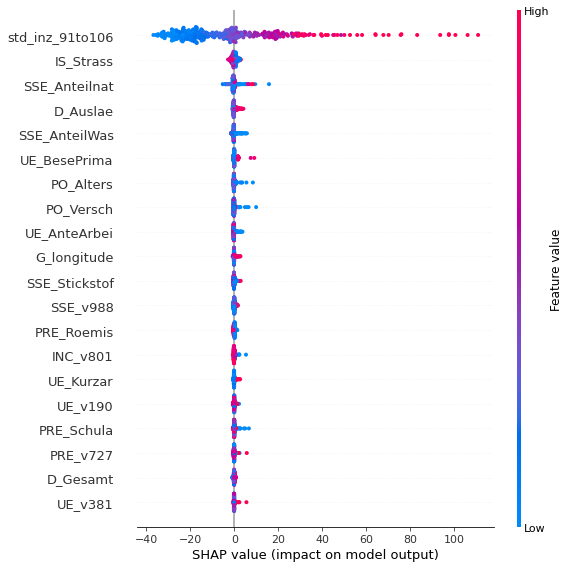

In [25]:
shap.summary_plot(shap_values, X,max_display=20) 

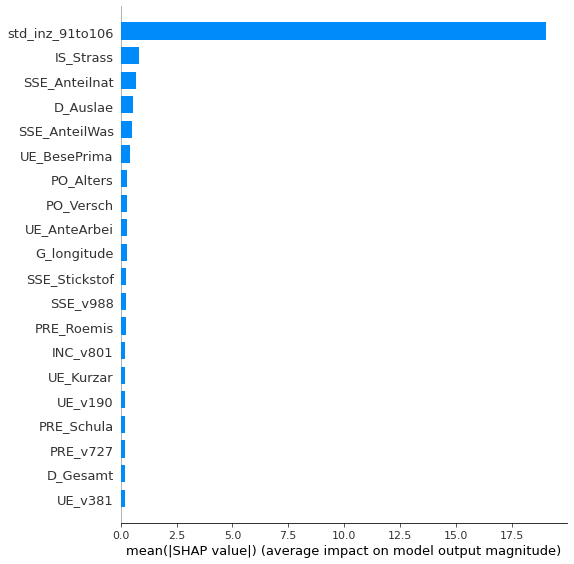

In [26]:
shap.summary_plot(shap_values, X, plot_type="bar",max_display=20)

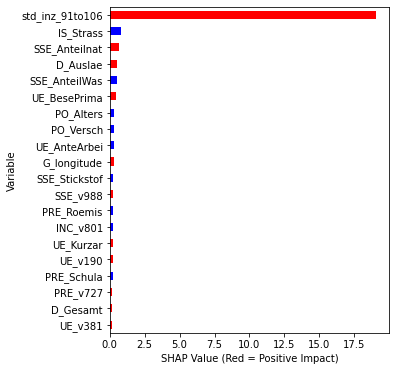

In [27]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[-20:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X) 

# CatBoost

In [8]:
shap_values_cb = shap.TreeExplainer(cb).shap_values(X)

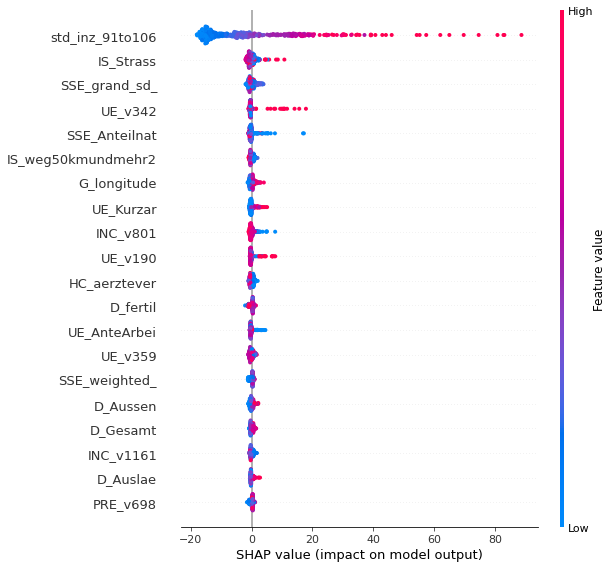

In [9]:
shap.summary_plot(shap_values_cb, X,max_display=20)  #TreeExpliner

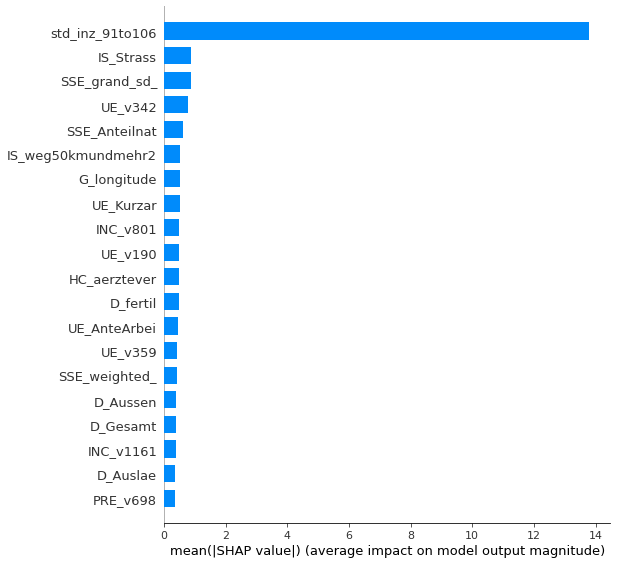

In [10]:
shap.summary_plot(shap_values_cb, X, plot_type="bar",max_display=20)

invalid value encountered in true_divide
invalid value encountered in true_divide


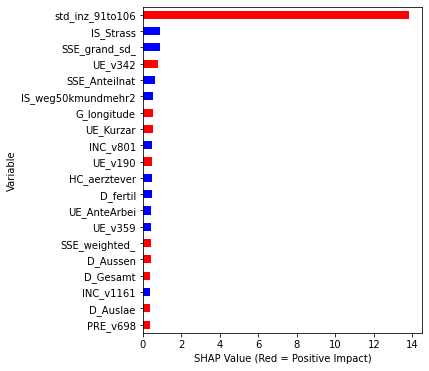

In [11]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    k2 = k2[-20:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(5,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values_cb,X) 

# CatBoost 20 most important vars

In [12]:
f = len(X.columns)
l = f-21
ll = f-11


In [13]:
top20feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][f:l:-1]
top10feature = X.columns[np.argsort(np.abs(shap_values_cb).mean(0))][f:ll:-1]

X[top20feature].describe()

,std_inz_91to106,IS_Strass,SSE_grand_sd_,UE_v342,SSE_Anteilnat,IS_weg50kmundmehr2,G_longitude,UE_Kurzar,INC_v801,UE_v190,HC_aerztever,D_fertil,UE_AnteArbei,UE_v359,SSE_weighted_,D_Aussen,D_Gesamt,INC_v1161,D_Auslae,PRE_v698
count,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000,401.000000
mean,79.007408,491.092926,0.597951,3.798502,5.101742,11.484290,9.866996,0.752618,2846.079834,11.710718,61.357845,1.632219,22.971313,68.926407,0.676074,4.806734,5.103242,35.613968,10.034920,32.458591
std,72.684265,87.669609,0.373193,3.631349,3.710643,3.481254,2.026269,1.440882,926.153870,3.008996,26.108397,0.134031,4.190943,11.196052,0.382720,6.630641,4.276379,15.809457,5.149193,8.857037
min,3.607589,275.799988,0.099060,-8.500000,0.900000,4.900000,6.083333,0.000000,28.000000,4.600000,8.400000,1.060000,14.500000,27.500000,0.143572,-13.900000,-14.000000,16.000000,1.900000,0.000000
25%,34.004898,431.399994,0.368171,1.700000,2.700000,9.000000,8.216666,0.000000,2706.000000,10.600000,44.700001,1.560000,19.500000,62.099998,0.421747,1.500000,2.500000,26.799999,6.200000,26.600000
50%,56.944515,476.399994,0.491239,4.200000,4.300000,10.800000,9.766666,0.300000,3052.000000,12.400000,52.900002,1.650000,22.700001,70.000000,0.583280,3.700000,5.100000,31.400000,9.200000,31.700001
75%,107.506599,545.000000,0.715293,6.200000,6.300000,13.300000,11.416667,0.900000,3329.000000,13.600000,71.099998,1.720000,25.900000,76.699997,0.811219,6.000000,7.500000,38.799999,13.100000,38.200001
max,721.384521,803.599976,3.336848,18.100000,34.000000,24.200001,14.983334,19.600000,4855.000000,20.200001,164.899994,1.940000,34.700001,95.099998,3.392816,65.900002,21.299999,178.800003,35.000000,57.900002


In [14]:
# initialize Pool
train_pool20 = Pool(data=X[top20feature],
                  label=Y,
                 feature_names = list(X[top20feature].columns))
 

# specify the training parameters 
model20 = CatBoostRegressor(random_seed=0,
                          logging_level="Silent"
                         )
#train the model
cb20 = model20.fit(train_pool20)

In [15]:
# prediction
preds20 = cb20.predict(train_pool20,
                    prediction_type="RawFormulaVal"
                  )
#print(Y.dtype)
preds20 = preds20.reshape(-1, 1)
#print(preds20)
from sklearn.linear_model import LinearRegression
from sklearn import metrics
reg20 = LinearRegression().fit(preds20, Y)
print("R2 linReg_model20: ", reg.score(preds20, Y))
print("RMSE linReg_model20: ",metrics.mean_squared_error(preds20, Y))


R2 linReg_model20:  0.9963351922896753
RMSE linReg_model20:  4.822590205656737


# R2 CatBoost top20

In [16]:
cb20.score(X[top20feature], Y)

0.9958684749262208

# cross validation

In [17]:
# all
import random
iterations = range(0,40)
r2_reg_k_test = list(range(0,40))
rmse_reg_k_test = list(range(0,40))
r2_cb_k_train = list(range(0,40))
r2_cb_k_test = list(range(0,40))
for i in iterations:
    rs = random.sample(range(0,401), 100)
    k_test_x = X.iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X.drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X.columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X.columns))
 
    model = CatBoostRegressor(random_seed=0, logging_level="Silent")
    #train the model
    cb_k = model.fit(train_pool_k)
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    from sklearn.linear_model import LinearRegression
    from sklearn import metrics
    reg_k = LinearRegression().fit(preds_k, k_test_y)
    print(i/len(iterations)*100, "% done; "," R2_reg_test:",reg_k.score(preds_k, k_test_y)) 
    #print("RMSE",metrics.mean_squared_error(preds_k, k_test_y)) 
    #print("R2_cb_train:",cb_k.score(train_pool_k)) 
    #print("R2_cb_test:",cb_k.score(test_pool_k))
    
    r2_reg_k_test[i] = reg_k.score(preds_k, k_test_y)
    rmse_reg_k_test[i] = metrics.mean_squared_error(preds_k, k_test_y)
    r2_cb_k_train[i] = cb_k.score(train_pool_k)
    r2_cb_k_test[i] =  cb_k.score(test_pool_k)

0.0 % done;   R2_reg_test: 0.5067970377924671
2.5 % done;   R2_reg_test: 0.5942810530724421
5.0 % done;   R2_reg_test: 0.46278989545331717
7.5 % done;   R2_reg_test: 0.349744757918236
10.0 % done;   R2_reg_test: 0.5101733425450626
12.5 % done;   R2_reg_test: 0.5025204469891004
15.0 % done;   R2_reg_test: 0.4260478670511094
17.5 % done;   R2_reg_test: 0.44589188904216437
20.0 % done;   R2_reg_test: 0.5068047218501963
22.5 % done;   R2_reg_test: 0.4624074112021094
25.0 % done;   R2_reg_test: 0.5398938098241064
27.500000000000004 % done;   R2_reg_test: 0.3934219661149504
30.0 % done;   R2_reg_test: 0.4967009467233997
32.5 % done;   R2_reg_test: 0.4516966558677299
35.0 % done;   R2_reg_test: 0.5412402644811876
37.5 % done;   R2_reg_test: 0.4101270070918469
40.0 % done;   R2_reg_test: 0.519753017101074
42.5 % done;   R2_reg_test: 0.37827523302550425
45.0 % done;   R2_reg_test: 0.46472528208141106
47.5 % done;   R2_reg_test: 0.4611526280028514
50.0 % done;   R2_reg_test: 0.3916352119040397
5

In [18]:
print("Mean R2 of linReg_modesl: ", sum(r2_reg_k_test)/len(r2_reg_k_test))
print("Mean R2 of CatBoost_models:",sum(r2_cb_k_train)/len(r2_cb_k_train))

Mean R2 of linReg_modesl:  0.47771351779171545
Mean R2 of CatBoost_models: 0.9997460588641027


In [20]:
import random
iterations = range(0,40)
r2_reg_k_test = list(range(0,40))
rmse_reg_k_test = list(range(0,40))
r2_cb_k_train = list(range(0,40))
r2_cb_k_test = list(range(0,40))
for i in iterations:
    rs = random.sample(range(0,401), 100)
    k_test_x = X[top20feature].iloc[rs]
    k_test_y = Y.iloc[rs]
    k_train_x = X[top20feature].drop(rs)
    k_train_y = Y.drop(rs)
    # initialize Pool 
    train_pool_k = Pool(data=k_train_x,
                        label=k_train_y,
                        feature_names = list(X[top20feature].columns))
        
    test_pool_k = Pool(data=k_test_x,
                       label=k_test_y,
                       feature_names = list(X[top20feature].columns))
 
    model = CatBoostRegressor(random_seed=0, logging_level="Silent")
    #train the model
    cb_k = model.fit(train_pool_k)
    # make the prediction using the resulting model
    preds_k = cb_k.predict(test_pool_k,
                    prediction_type="RawFormulaVal"
                  )
    preds_k = preds_k.reshape(-1, 1)
    #LinearRegression
    from sklearn.linear_model import LinearRegression
    from sklearn import metrics
    reg_k = LinearRegression().fit(preds_k, k_test_y)
    print(i/len(iterations)*100, "% done; "," R2_reg_test:",reg_k.score(preds_k, k_test_y)) 
    #print("RMSE",metrics.mean_squared_error(preds_k, k_test_y)) 
    #print("R2_cb_train:",cb_k.score(train_pool_k)) 
    #print("R2_cb_test:",cb_k.score(test_pool_k))
    
    r2_reg_k_test[i] = reg_k.score(preds_k, k_test_y)
    rmse_reg_k_test[i] = metrics.mean_squared_error(preds_k, k_test_y)
    r2_cb_k_train[i] = cb_k.score(train_pool_k)
    r2_cb_k_test[i] =  cb_k.score(test_pool_k)

0.0 % done;   R2_reg_test: 0.5861924057177499
2.5 % done;   R2_reg_test: 0.7264626724619188
5.0 % done;   R2_reg_test: 0.5882298710897955
7.5 % done;   R2_reg_test: 0.5880120550289152
10.0 % done;   R2_reg_test: 0.48307234765839846
12.5 % done;   R2_reg_test: 0.48523545467988727
15.0 % done;   R2_reg_test: 0.4204474020935983
17.5 % done;   R2_reg_test: 0.5272978276793292
20.0 % done;   R2_reg_test: 0.5710641728404648
22.5 % done;   R2_reg_test: 0.5704141972716292
25.0 % done;   R2_reg_test: 0.5384774114855937
27.500000000000004 % done;   R2_reg_test: 0.4662925428745236
30.0 % done;   R2_reg_test: 0.579540881495239
32.5 % done;   R2_reg_test: 0.598649108982187
35.0 % done;   R2_reg_test: 0.5518867458978811
37.5 % done;   R2_reg_test: 0.5016978842225717
40.0 % done;   R2_reg_test: 0.5459357949905589
42.5 % done;   R2_reg_test: 0.5986140394724175
45.0 % done;   R2_reg_test: 0.5804116111186428
47.5 % done;   R2_reg_test: 0.6208717511634756
50.0 % done;   R2_reg_test: 0.5795012782839815
52.

In [21]:
print("Mean R2 of linReg_modesl: ", sum(r2_reg_k_test)/len(r2_reg_k_test))
print("Mean R2 of CatBoost_models:",sum(r2_cb_k_train)/len(r2_cb_k_train))

Mean R2 of linReg_modesl:  0.5451370485049968
Mean R2 of CatBoost_models: 0.9982015945765574
